In [1]:
using Plots
using LinearAlgebra

In [28]:
# resolve u_t = u_xx pelo metodo explicito
# input:
#       h = espacamento em x
#       n = numero de passos em t
#       c = 5/11 ou 5/9 como pedido do enunciado
# output:
#       m,n = dimensoes do grid
#       x = range de 0 a 1 com m divisoes
#       t = array com todos os passos em t
#       U = matriz com a solucao em cada t_i
function heat_euler(h,k,n)
    # para simplificar as expressoes, armazena k/h^2 em uma variavel
    r = k/(h^2)
    # cria um range de 0 a 1 baseado em h
    m = Int(ceil(1/h))+1
    x = LinRange(0,1,m)
    # inicia a matriz do sistema linear
    A = Tridiagonal(r*ones(m-3), (1-2*r)*ones(m-2), r*ones(m-3))
    # funcao para calcular as condicoes iniciais em t=0
    function f(x)
        if x<=0.5
            return 2*x
        end
        
        if x > 0.5
            return 2-2*x
        end
    end
    # inicializa a matriz que recebe as aproximacoes
    U = zeros(m,n)
    # insere as condicoes iniciais em t=0
    U[:,1] .= f.(x)
    # inicializa o array que armazena os t_i
    t = zeros(n)
    t[1] = k
    # calcula a aproximacao para cada t_i
    for j=2:n
        b = zeros(m-2)
        b[1] = r*U[1,j-1]
        b[m-2] = r*U[m,j-1]
        U[2:m-1,j] = A*U[2:m-1,j-1] + b
        
        t[j] = j*k
    end
    
    return m,n,x,t,U
end

heat_euler (generic function with 1 method)

In [29]:
# resolve u_t = u_xx pelo metodo crank-nicolson
# input:
#       h = espacamento em x
#       n = numero de passos em t
#       c = 5/11 ou 5/9 como pedido do enunciado
# output:
#       m,n = dimensoes do grid
#       x = range de 0 a 1 com m divisoes
#       t = array com todos os passos em t
#       U = matriz com a solucao em cada t_i
function heat_cn(h,k,n)
    
    # para simplificar as expressoes, armazena k/h^2 em uma variavel
    r = k/(2*h^2)
    # cria um range de 0 a 1 baseado em h    
    m = Int(ceil(1/h))+1
    x = LinRange(0,1,m)
    # inicia as matrizes do sistema linear
    A = Tridiagonal(-r*ones(m-3), (1+2*r)*ones(m-2), -r*ones(m-3))
    B = Tridiagonal(r*ones(m-3), (1-2*r)*ones(m-2), r*ones(m-3))
    # funcao para calcular as condicoes iniciais em t=0    
    function f(x)
        if x<=0.5
            return 2*x
        end
        
        if x > 0.5
            return 2-2*x
        end
    end
    # inicializa a matriz que recebe as aproximacoes    
    U = zeros(m,n)
    # insere as condicoes iniciais em t=0
    U[:,1] .= f.(x)
    # inicializa o array que armazena os t_i    
    t = zeros(n)
    t[1] = 0 
    # calcula a aproximacao para cada t_i    
    for j=2:n
        b = zeros(m-2)
        b[1] = r*U[1,j-1]
        b[m-2] = r*U[m,j-1]
        rhs = B*U[2:m-1,j-1] + b
        
        U[2:m-1,j] = A\rhs
        
        t[j] = j*k
    end
    
    return m,n,x,t,U
end

heat_cn (generic function with 1 method)

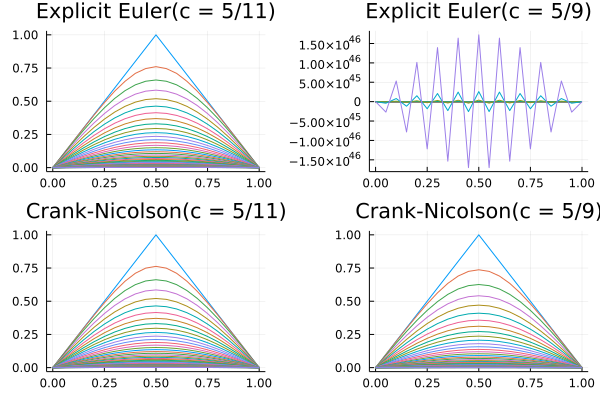

In [225]:
# Plots
h = 0.05
k1 = (5/11)*h^2
k2 = (5/9)*h^2

m1,n1,x1,t1,U1 = heat_euler(h,k1,600)
plt1 = plot()
for i=1:10:n1
    plot!(plt1, x1, U1[:,i], legend=false, title="Explicit Euler(c = 5/11)")
end

m2,n2,x2,t2,U2 = heat_euler(h,k2,600)
plt2 = plot()
for i=1:10:n2
    plot!(plt2, x2, U2[:,i], legend=false, title="Explicit Euler(c = 5/9)")
end

mc1,nc1,xc1,tc1,Uc1 = heat_cn(h,k1,600)
pltc1 = plot()
for i=1:10:nc1
    plot!(pltc1, xc1, Uc1[:,i], legend=false, title="Crank-Nicolson(c = 5/11)")
end

mc2,nc2,xc2,tc2,Uc2 = heat_cn(h,k2,600)
pltc2 = plot()
for i=1:10:nc2
    plot!(pltc2, xc2, Uc2[:,i], legend=false, title="Crank-Nicolson(c = 5/9)")
end

u((x,t),n) = (8/pi^2)*sum([(1/i^2)*sin(0.5*i*pi)*sin(i*pi*x)*exp(-(i^2)*(pi^2)*t) for i=1:n])
create_Grid(x,t) = [[(i,j) for i in x] for j in t]

l = @layout [a b; c d]
plot(plt1, plt2, pltc1, pltc2, layout = 4, fmt=:png)

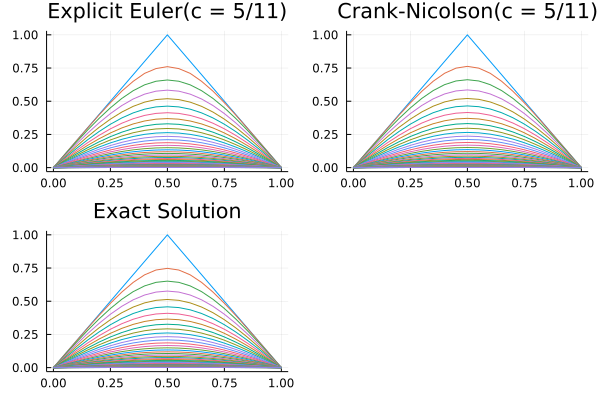

In [226]:
l= @layout [a b c]
plte = plot()
Ue = [u.(create_Grid(xc1,tc1)[i],10000) for i=1:n1]
Ue = hcat(Ue...)
for i=1:10:n1
   plot!(plte, x1, Ue[:,i], legend=false, title="Exact Solution")
end
plot(plt1, pltc1, plte, layout = 3, fmt=:png)

In [222]:
function get_Error(c, method)
    
    h = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125]
    error_h = zeros(6)
    error_k = zeros(6)

    if method == "euler"
        k = c*h.*h
        for j=1:6
            m,n,x,t,U = heat_euler(h[j],k[j],300)
            Ue = [u.(create_Grid(x,t)[i],10000) for i=1:n]
            Ue = hcat(Ue...)        
            error_k[j] = sqrt(k[j])*norm(U[Int(floor(length(x)/2)),:] - Ue[Int(floor(length(x)/2)),:])
            error_h[j] = sqrt(h[j])*norm(U[:,3] - Ue[:,3])               
        end
    end
    
    if method == "cn"
        k = c*h
        for j=1:6
            m,n,x,t,U = heat_cn(h[j],k[j],300)
            Ue = [u.(create_Grid(x,t)[i],10000) for i=1:n]
            Ue = hcat(Ue...)          
            error_k[j] = sqrt(k[j])*norm(U[Int(floor(length(x)/2)),:] - Ue[Int(floor(length(x)/2)),:])
            error_h[j] = sqrt(h[j])*norm(U[:, 3] - Ue[:, 3])              
        end
    end    

    return error_h, error_k, h, k
end

get_Error (generic function with 1 method)

In [229]:
euler_h, euler_k, h1, k1 = get_Error(0.2, "euler")
cn_h, cn_k, h2, k2 = get_Error(0.2, "cn")

([0.07354896845724564, 0.04604054610260013, 0.027197407904640723, 0.016061144641531425, 0.009513548480521591, 0.005645275740107201], [0.0314286516393411, 0.018081656557952956, 0.009993322226509798, 0.005443384675706675, 0.002942736274195476, 0.0015725346347432063], [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125], [0.020000000000000004, 0.010000000000000002, 0.005000000000000001, 0.0025000000000000005, 0.0012500000000000002, 0.0006250000000000001])

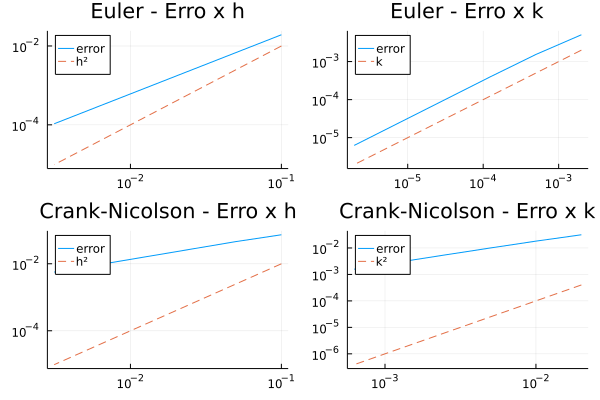

In [230]:
plt_eulerh = plot(xaxis=:log, yaxis=:log, legend=:topleft, title="Euler - Erro x h")
plot!(plt_eulerh, h1, euler_h, label="error")
plot!(plt_eulerh, h1, h1.*h1, label="h²", line=:dash)

plt_eulerk = plot(xaxis=:log, yaxis=:log, legend=:topleft, title="Euler - Erro x k")
plot!(plt_eulerk, k1, euler_k, label="error")
plot!(plt_eulerk, k1, k1, label="k", line=:dash)

plt_cnh = plot(xaxis=:log, yaxis=:log, legend=:topleft, title="Crank-Nicolson - Erro x h")
plot!(plt_cnh, h2, cn_h, xaxis=:log, yaxis=:log, label = "error", legend =:topleft)
plot!(plt_cnh, h2, h2.*h2, label = "h²", line=:dash)

plt_cnk = plot(xaxis=:log, yaxis=:log, legend=:topleft, title="Crank-Nicolson - Erro x k")
plot!(plt_cnk, k2, cn_k, xaxis=:log, yaxis=:log, label = "error", legend =:topleft)
plot!(plt_cnk, k2, k2.*k2, label = "k²", line=:dash)

plot(plt_eulerh, plt_eulerk, plt_cnh, plt_cnk, fmt=:png)